#### Read, Clean, And Split Data

In [21]:
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100)

messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
messages.columns = ['label', 'text']
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels,
                                                    test_size=0.2)

Prepare Data For Modeling

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Initialize and filt the tokenizer

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

Use that tokenizer to transform the text messages in the training and test sets

In [24]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

First item of train set

In [25]:
X_train_seq[0]

[1,
 34,
 2579,
 1,
 67,
 2,
 48,
 2,
 3773,
 2013,
 149,
 19,
 1,
 604,
 2579,
 42,
 49,
 1,
 55,
 52,
 98,
 117,
 49,
 2,
 28,
 82,
 389,
 150,
 118,
 61]

Pad the sequences so each sequence is the same length

In [26]:
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [27]:
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    1,   34,
       2579,    1,   67,    2,   48,    2, 3773, 2013,  149,   19,    1,
        604, 2579,   42,   49,    1,   55,   52,   98,  117,   49,    2,
         28,   82,  389,  150,  118,   61], dtype=int32)

#### Build Model

Import the tools needed from keras and define functions to calculate recall and precision.

In [28]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

Construct a simple RNN model

In [29]:
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          252608    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 260,963
Trainable params: 260,963
Non-trainable params: 0
_________________________________________________________________


Compile the model:

In [30]:
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

Fit the RNN Model

In [31]:
history = model.fit(X_train_seq_padded, y_train,
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 13s 55ms/step - loss: 0.3669 - accuracy: 0.8685 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.1738 - val_accuracy: 0.8556 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
140/140 [==============================] - 6s 45ms/step - loss: 0.1295 - accuracy: 0.9179 - precision_m: 0.4135 - recall_m: 0.3701 - val_loss: 0.1304 - val_accuracy: 0.9839 - val_precision_m: 1.0000 - val_recall_m: 0.9016
Epoch 3/10
140/140 [==============================] - 6s 45ms/step - loss: 0.1033 - accuracy: 0.9910 - precision_m: 0.9837 - recall_m: 0.9259 - val_loss: 0.1299 - val_accuracy: 0.9785 - val_precision_m: 1.0000 - val_recall_m: 0.8609
Epoch 4/10
140/140 [==============================] - 6s 46ms/step - loss: 0.0883 - accuracy: 0.9957 - precision_m: 0.9826 - recall_m: 0.9612 - val_loss: 0.1376 - val_accuracy: 0.9821 - val_precision_m: 1.0000 - val_recall_m: 0.8840
Epoch 5/10
140/140 [==============================]

Plot the evaluation metrics by each epoch fot the model to see if we are over or underfitting.

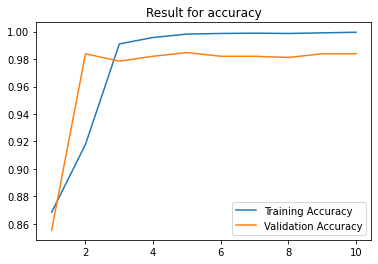

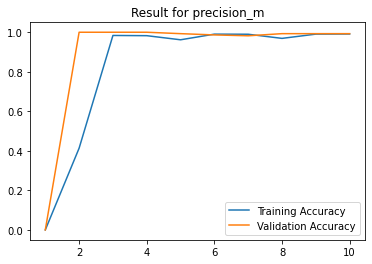

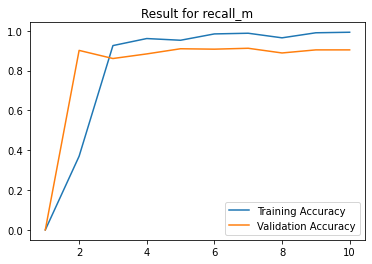

In [32]:
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
  acc = history.history[i]
  val_acc = history.history['val_{}'.format(i)]
  epochs = range(1, len(acc) + 1)

  plt.figure()
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title('Result for {}'.format(i))
  plt.legend()
  plt.show()